In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,MobileNet, InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random


In [2]:
def plot_output_graphs(model):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


In [2]:
def confusion_mat(predictions,val_data,class_names):
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes

    confusion_mtx = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [3]:
num_classes = 4
train_data_dir = './Dataset/train'
validation_data_dir = './Dataset/validation/'

train_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
class_names= ['CNV', 'DME', 'DRUSEN', 'NORMAL'] 

<h2> VGG16</h2>

In [5]:
batch_size = 32

train_generatorM1 = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generatorM1 = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 20000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


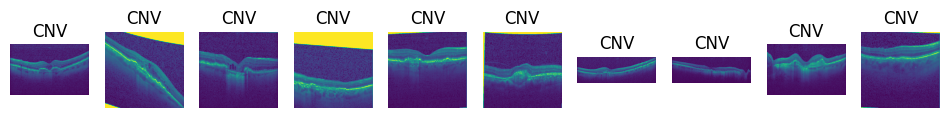

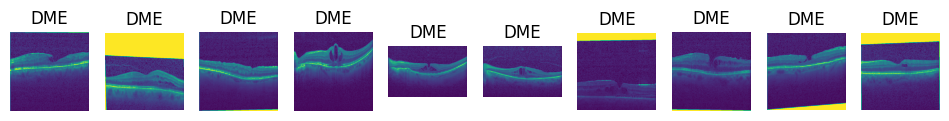

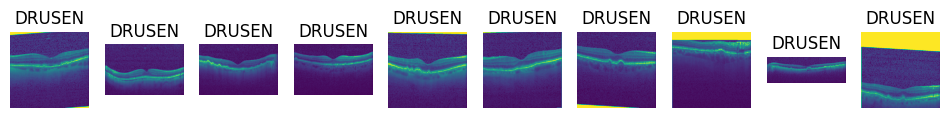

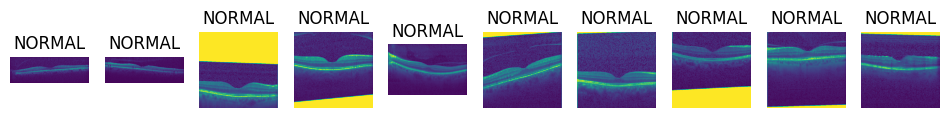

In [6]:
num_images_to_display = 10

for class_label in class_names:
    class_index = train_generatorM1.class_indices[class_label]
    class_images = [image for image, label in zip(train_generatorM1.filepaths, train_generatorM1.labels) if label == class_index]

    num_images = min(num_images_to_display, len(class_images))
    selected_images = random.sample(class_images, num_images)
    
    plt.figure(figsize=(12, 4))
    
    for i, image_path in enumerate(selected_images):
        img = plt.imread(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_label)
        plt.axis('off')
    
    plt.show()

In [12]:
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)



In [13]:
model_vgg = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
epochs=15

modelM1 = model_vgg.fit(train_generatorM1, epochs=epochs, validation_data=validation_generatorM1)


Epoch 1/15
625/625 [==============================] - 180s 286ms/step - loss: 0.7723 - accuracy: 0.6827 - val_loss: 0.5276 - val_accuracy: 0.7857
Epoch 2/15
625/625 [==============================] - 186s 298ms/step - loss: 0.5285 - accuracy: 0.7984 - val_loss: 0.5581 - val_accuracy: 0.7565
Epoch 3/15
625/625 [==============================] - 187s 299ms/step - loss: 0.4695 - accuracy: 0.8214 - val_loss: 0.3831 - val_accuracy: 0.8550
Epoch 4/15
625/625 [==============================] - 192s 308ms/step - loss: 0.4164 - accuracy: 0.8456 - val_loss: 0.3868 - val_accuracy: 0.8558
Epoch 5/15
625/625 [==============================] - 193s 309ms/step - loss: 0.3872 - accuracy: 0.8547 - val_loss: 0.3949 - val_accuracy: 0.8522
Epoch 6/15
625/625 [==============================] - 193s 308ms/step - loss: 0.3680 - accuracy: 0.8637 - val_loss: 0.3744 - val_accuracy: 0.8602
Epoch 7/15
625/625 [==============================] - 194s 310ms/step - loss: 0.3434 - accuracy: 0.8733 - val_loss: 0.3349 -

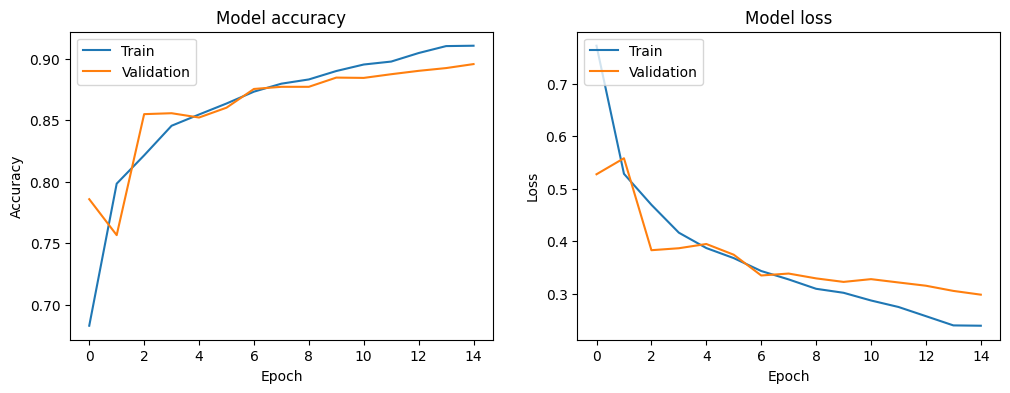

In [15]:
plot_output_graphs(modelM1)

In [ ]:
model_vgg.save("./VGG16_model.h5")

In [6]:
loaded_modelM1 = tf.keras.models.load_model("./VGG16_model.h5")
Y_pred_vgg = loaded_modelM1.predict(validation_generatorM1, len(validation_generatorM1))

125/125 [==============================] - 36s 215ms/step


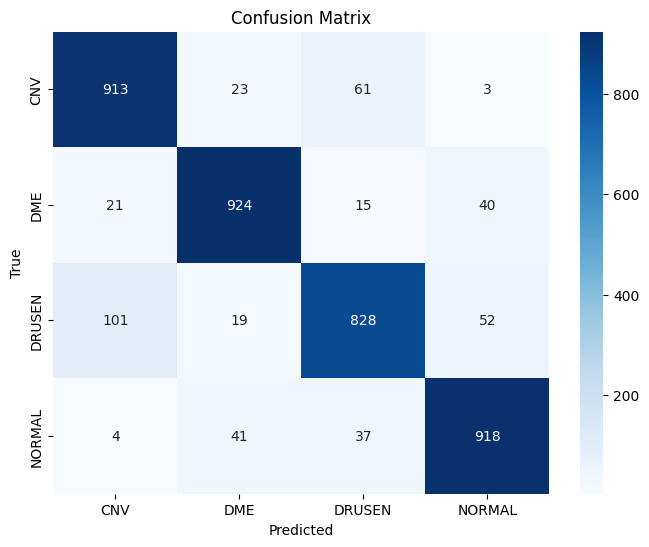

Classification Report:
              precision    recall  f1-score   support

         CNV       0.88      0.91      0.90      1000
         DME       0.92      0.92      0.92      1000
      DRUSEN       0.88      0.83      0.85      1000
      NORMAL       0.91      0.92      0.91      1000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000

Validation Accuracy: 89.58%


In [7]:

confusion_mat(Y_pred_vgg,validation_generatorM1,class_names)
true_labels_M1 = validation_generatorM1.classes
predicted_labels_M1 = np.argmax(Y_pred_vgg, axis=1)  # Convert one-hot encoded predictions to class indices
accuracy = accuracy_score(true_labels_M1, predicted_labels_M1)
classification_rep = classification_report(true_labels_M1, predicted_labels_M1, target_names=class_names)
print("Classification Report:")
print(classification_rep)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

<h2>MobileNetV2</h2>

In [8]:
batch_size = 32

train_generatorM2 = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generatorM2 = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 20000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


In [ ]:

base_model_mob = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_mob = base_model_mob.output
x_mob = Flatten()(x_mob)
x_mob = Dense(1024, activation='relu')(x_mob)
x_mob = Dropout(0.4)(x_mob)
predictions_mob = Dense(num_classes, activation='softmax')(x_mob)

model_mob = Model(inputs=base_model_mob.input, outputs=predictions_mob)

for layer in base_model_mob.layers:
    layer.trainable = False

model_mob.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [7]:

epochs_mob = 15
mob_mod=model_mob.fit(train_generatorM2, epochs=epochs_mob, validation_data=validation_generatorM2)


Epoch 1/15
625/625 [==============================] - 78s 119ms/step - loss: 2.3841 - accuracy: 0.7445 - val_loss: 0.4327 - val_accuracy: 0.8430
Epoch 2/15
625/625 [==============================] - 68s 108ms/step - loss: 0.4771 - accuracy: 0.8262 - val_loss: 0.4612 - val_accuracy: 0.8340
Epoch 3/15
625/625 [==============================] - 66s 106ms/step - loss: 0.4123 - accuracy: 0.8493 - val_loss: 0.3958 - val_accuracy: 0.8587
Epoch 4/15
625/625 [==============================] - 69s 110ms/step - loss: 0.3712 - accuracy: 0.8637 - val_loss: 0.3838 - val_accuracy: 0.8715
Epoch 5/15
625/625 [==============================] - 69s 110ms/step - loss: 0.3626 - accuracy: 0.8662 - val_loss: 0.3645 - val_accuracy: 0.8748
Epoch 6/15
625/625 [==============================] - 68s 109ms/step - loss: 0.3273 - accuracy: 0.8786 - val_loss: 0.3607 - val_accuracy: 0.8775
Epoch 7/15
625/625 [==============================] - 64s 103ms/step - loss: 0.3116 - accuracy: 0.8889 - val_loss: 0.3703 - val_ac

In [8]:
model_mob.save('./MobNet_model.h5')


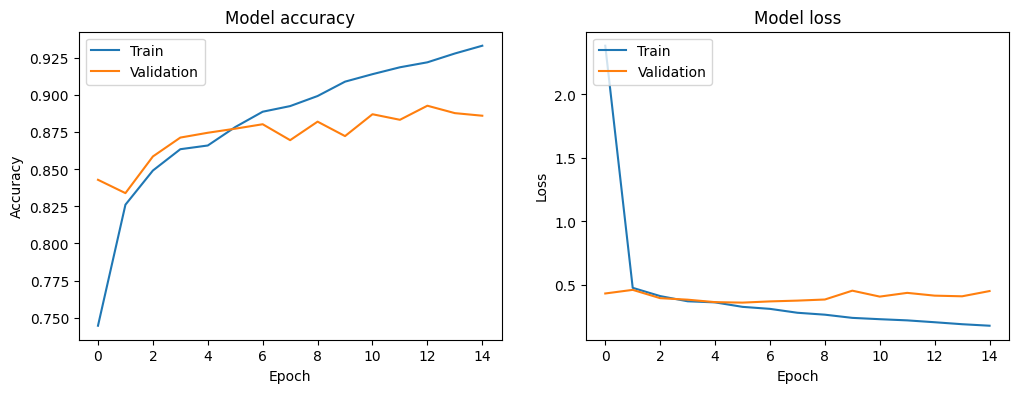

In [9]:
plot_output_graphs(mob_mod)

In [9]:
loaded_modelM2 = tf.keras.models.load_model("./MobNet_model.h5")
Y_pred = loaded_modelM2.predict(validation_generatorM2, len(validation_generatorM2))

125/125 [==============================] - 15s 106ms/step


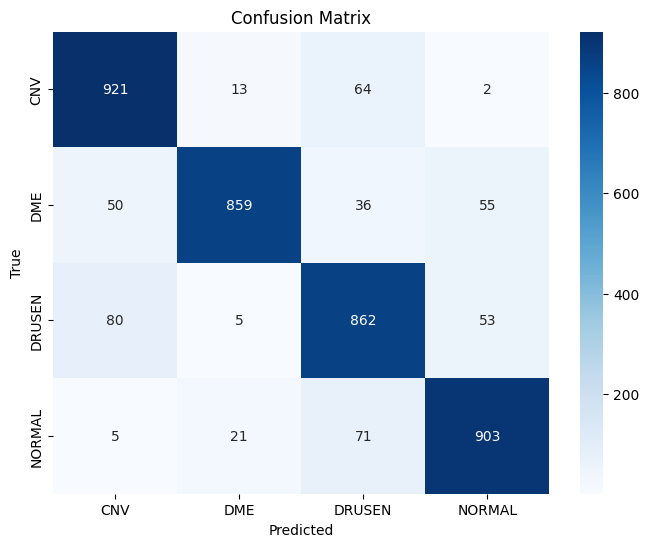

Validation Accuracy: 88.62%
Classification Report:
              precision    recall  f1-score   support

         CNV       0.87      0.92      0.90      1000
         DME       0.96      0.86      0.91      1000
      DRUSEN       0.83      0.86      0.85      1000
      NORMAL       0.89      0.90      0.90      1000

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



In [10]:

confusion_mat(Y_pred,validation_generatorM2,class_names)
true_labels_M2 = validation_generatorM2.classes
predicted_labels_M2 = np.argmax(Y_pred, axis=1)  # Convert one-hot encoded predictions to class indices
accuracy = accuracy_score(true_labels_M2, predicted_labels_M2)
classification_rep = classification_report(true_labels_M2, predicted_labels_M2, target_names=class_names)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_rep)


<h2>InceptionV3</h2>

In [4]:
batch_size = 16

train_generatorM3 = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generatorM3 = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 20000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


In [6]:
base_model_rn = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_rn = base_model_rn.output
x_rn = Flatten()(x_rn)
x_rn = Dense(1024, activation='sigmoid')(x_rn)
x_rn = Dropout(0.4)(x_rn)
predictions_rn = Dense(num_classes, activation='softmax')(x_rn)

model_rn = Model(inputs=base_model_rn.input, outputs=predictions_rn)

model_rn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
modelM3 = model_rn.fit(
    train_generatorM3, 
    epochs=10, 
    validation_data=validation_generatorM3  
)


model_rn.save('./IncpV3_trained_model.h5')

Epoch 1/10
1250/1250 [==============================] - 352s 271ms/step - loss: 0.4169 - accuracy: 0.8560 - val_loss: 0.1923 - val_accuracy: 0.9370
Epoch 2/10
1250/1250 [==============================] - 286s 229ms/step - loss: 0.2189 - accuracy: 0.9301 - val_loss: 0.1808 - val_accuracy: 0.9392
Epoch 3/10
1250/1250 [==============================] - 290s 232ms/step - loss: 0.1520 - accuracy: 0.9506 - val_loss: 0.1771 - val_accuracy: 0.9410
Epoch 4/10
1250/1250 [==============================] - 300s 240ms/step - loss: 0.1245 - accuracy: 0.9600 - val_loss: 0.1457 - val_accuracy: 0.9520
Epoch 5/10
1250/1250 [==============================] - 287s 230ms/step - loss: 0.0978 - accuracy: 0.9703 - val_loss: 0.1644 - val_accuracy: 0.9480
Epoch 6/10
1250/1250 [==============================] - 287s 230ms/step - loss: 0.0848 - accuracy: 0.9742 - val_loss: 0.2023 - val_accuracy: 0.9438
Epoch 7/10
1250/1250 [==============================] - 287s 229ms/step - loss: 0.0665 - accuracy: 0.9798 - val_

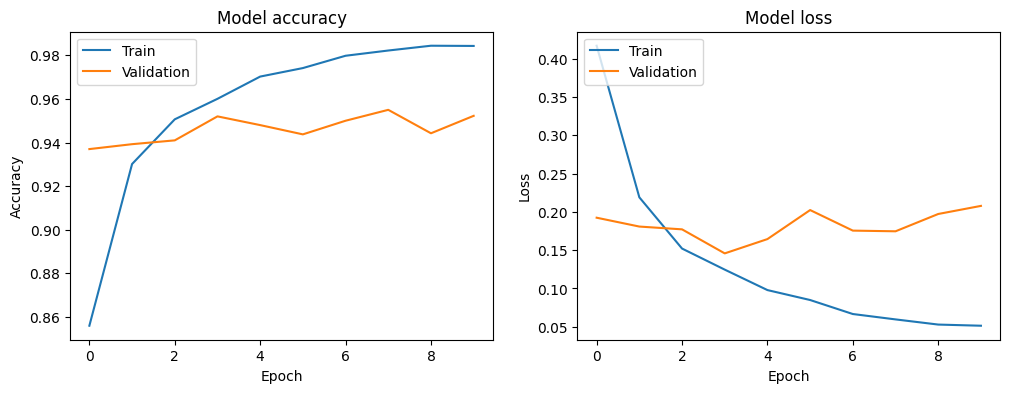

In [8]:
plot_output_graphs(modelM3)

In [5]:
loaded_modelM3 = tf.keras.models.load_model("./IncpV3_trained_model.h5")
Y_pred_M3 = loaded_modelM3.predict(validation_generatorM3, len(validation_generatorM3))

250/250 [==============================] - 19s 56ms/step


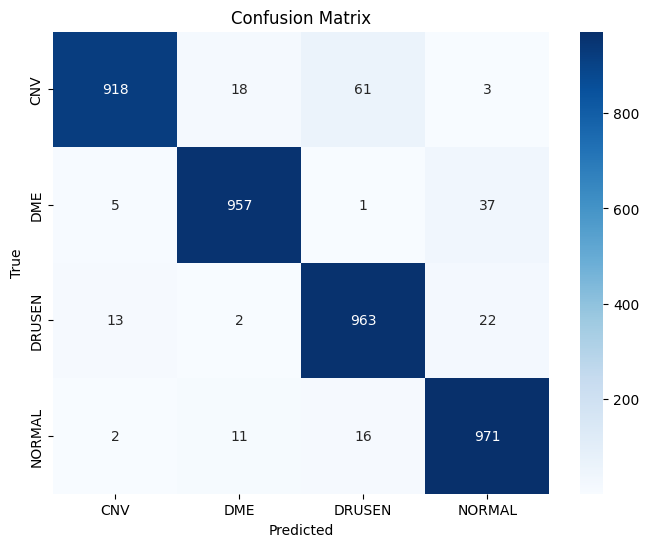

Classification Report:
              precision    recall  f1-score   support

         CNV       0.98      0.92      0.95      1000
         DME       0.97      0.96      0.96      1000
      DRUSEN       0.93      0.96      0.94      1000
      NORMAL       0.94      0.97      0.96      1000

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000

Validation Accuracy: 95.23%


In [6]:
confusion_mat(Y_pred_M3,validation_generatorM3,class_names)
true_labels_M3 = validation_generatorM3.classes
predicted_labels_M3 = np.argmax(Y_pred_M3, axis=1)  # Convert one-hot encoded predictions to class indices
accuracy = accuracy_score(true_labels_M3, predicted_labels_M3)
classification_rep = classification_report(true_labels_M3, predicted_labels_M3, target_names=class_names)
print("Classification Report:")
print(classification_rep)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

<h3>Testing</h3>


<p>We can see from the above three models that the VGG16 model runs the best among all the other models without much overfitting.</p>

In [2]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [3]:
batch_size = 32
test_dir = "./Dataset/test"
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 10000 images belonging to 1 classes.


In [4]:
print("Number of test samples:", test_generator.samples)

Number of test samples: 10000


In [5]:
model_final = tf.keras.models.load_model("./VGG16_model.h5")


In [6]:
predictionsF = model_final.predict(test_generator)
predicted_labelsF = np.argmax(predictionsF, axis=1)

313/313 [==============================] - 82s 231ms/step


In [7]:
predicted_labelsF[:100], predicted_labelsF.shape

(array([3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 1, 0, 0, 3, 3, 0, 0, 1, 3, 1, 0,
        3, 3, 1, 0, 0, 0, 0, 3, 2, 0, 1, 3, 0, 0, 3, 3, 0, 0, 3, 3, 3, 0,
        0, 3, 0, 3, 0, 0, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 1, 3,
        0, 3, 3, 0, 3, 3, 0, 0, 0, 3, 0, 2, 0, 1, 0, 3, 3, 3, 0, 0, 1, 3,
        3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64),
 (10000,))

In [9]:
count={}
for i in predicted_labelsF:
    try:
        count[i]+=1
    except:
        count[i]=1
print(f'The distribution of predicted test labels: {count}')

The distribution of predicted test labels: {3: 4895, 1: 936, 0: 3392, 2: 777}


In [10]:
test_class_prediction =[]
for i in predicted_labelsF:
    if i==0:
        test_class_prediction.append("CNV")
    elif i==1:
        test_class_prediction.append("DME")
    elif i==2:
        test_class_prediction.append("DRUSEN")
    elif i==3:
        test_class_prediction.append("NORMAL")
print("The predicted classes for test set:",test_class_prediction[:25])

The predicted classes for test set: ['NORMAL', 'DME', 'NORMAL', 'NORMAL', 'DME', 'NORMAL', 'CNV', 'DME', 'NORMAL', 'NORMAL', 'NORMAL', 'DME', 'CNV', 'CNV', 'NORMAL', 'NORMAL', 'CNV', 'CNV', 'DME', 'NORMAL', 'DME', 'CNV', 'NORMAL', 'NORMAL', 'DME']


In [11]:
df = pd.DataFrame(test_class_prediction, columns=["Classes"])
df.to_csv("test_classes_prediction.csv", index=False,header=False) 